# LAB4: Transformers and ViT LAB
Author: Vittorio Pipoli (vittorio.pipoli@unimore.it)

Credits: Alexander Wan, Aryan Jain

### Assignment Goals


1. Familiarity with the Vision Transformer architecture
2. Familiarity with the self-attention mechanism
3. Practice with PyTorch matrix operations



### Tasks
1. Implement multi-head self-attention (paper: https://arxiv.org/pdf/1706.03762.pdf)
2. Incorporate that into a ViT (paper: https://arxiv.org/pdf/2010.11929.pdf)

### Runtime Acceleration
Colab limits GPU usage, so set `device` below as `'cpu'` and change your runtime to CPU as well (Runtime > Change runtime type) when you're developing, and only change it to `'cuda'` (and your runtime to GPU) when you're ready to train.

In [1]:
#device = 'cpu'
device = 'cuda'

### Multi-head self-attention
Begin by implementing multiheaded self-attention. Do **not** use any `for` loops, and instead put all of the calculations into [batch matrix multiplications](https://pytorch.org/docs/stable/generated/torch.bmm.html), [Linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) or use [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html).



In [2]:
import torch.nn.functional as F
from torch import nn
import torch
import math

class MSA(nn.Module):
  def __init__(self, input_dim, embed_dim, num_heads, return_attn_weights=False): # edited for Extra 2
    '''
    input_dim: Dimension of input token embeddings
    embed_dim: Dimension of internal key, query, and value embeddings
    num_heads: Number of self-attention heads
    '''

    super().__init__()

    self.return_attn_weights = return_attn_weights # Added for Extra 2

    self.input_dim = input_dim
    self.embed_dim = embed_dim
    self.num_heads = num_heads

    self.K_embed = nn.Linear(input_dim, embed_dim, bias=False)
    self.Q_embed = nn.Linear(input_dim, embed_dim, bias=False)
    self.V_embed = nn.Linear(input_dim, embed_dim, bias=False)
    self.out_embed = nn.Linear(embed_dim, embed_dim, bias=False)

  def forward(self, x):
    '''
    x: input of shape (batch_size, max_length, input_dim)
    return: output of shape (batch_size, max_length, embed_dim)
    '''

    batch_size, max_length, given_input_dim = x.shape
    assert given_input_dim == self.input_dim
    assert self.embed_dim % self.num_heads == 0

    # You shouldn't need to initialize any new modules. Everything you need is
    # already in __init__

    # HINT: If you're stuck on how to handle multiple heads without for loops, try to
    # reshape matrix such that the batch_size is num_heads * batch_size
    # e.g. if you have two heads, you'd be doing self-attention twice per instance
    # in the batch, so you essentially have batch_size * 2

    # this implementation projects KQV before splitting into multiple heads
    # but you can also split into multiple heads first

    # compute K, Q, V
    K = self.K_embed(x) # (batch_size, max_length, embed_dim)
    # TODO: Compute Q
    Q = self.Q_embed(x)
    # TODO: Compute V
    V = self.V_embed(x)

    # TODO: split each KQV into heads, by reshaping each into (batch_size, max_length, self.num_heads, indiv_dim)
    indiv_dim = self.embed_dim // self.num_heads
    K = K.reshape(batch_size, max_length, self.num_heads, indiv_dim) # TODO
    Q = Q.reshape(batch_size, max_length, self.num_heads, indiv_dim)  # TODO
    V = V.reshape(batch_size, max_length, self.num_heads, indiv_dim)  # TODO

    K = K.permute(0, 2, 1, 3) # (batch_size, num_heads, max_length, embed_dim / num_heads)
    Q = Q.permute(0, 2, 1, 3)
    V = V.permute(0, 2, 1, 3)

    K = K.reshape(batch_size * self.num_heads, max_length, indiv_dim)
    Q = Q.reshape(batch_size * self.num_heads, max_length, indiv_dim)
    V = V.reshape(batch_size * self.num_heads, max_length, indiv_dim)

    # transpose and batch matrix multiply
    K_T = K.permute(0, 2, 1) # This is our K transposed so we can do a simple batched matrix multiplication (see torch.bmm for more details and the quick solution)
    QK = torch.bmm(Q, K_T) # TODO: Compute the weights before dividing by square root of d (batch_size * num_heads, max_length, max_length)

    # calculate weights by dividing everything by the square root of d (self.embed_dim)
    weights = QK / math.sqrt(self.embed_dim) # TODO
    weights = F.softmax(weights, dim=-1) # TODO Take the softmax over the last dimension (see torch.functional.Softmax) (batch_size * num_heads, max_length, max_length)

    w_V = weights @ V # weights is (batch_size * num_heads, max_length, max_length) and V is (batch_size * self.num_heads, max_length, indiv_dim), so we want the matrix product of weights @ V

    # rejoin heads
    w_V = w_V.reshape(batch_size, self.num_heads, max_length, indiv_dim)
    w_V = w_V.permute(0, 2, 1, 3) # (batch_size, max_length, num_heads, embed_dim / num_heads)
    w_V = w_V.reshape(batch_size, max_length, self.embed_dim)

    out = self.out_embed(w_V)

    if self.return_attn_weights: # added for Extra 2
      return out, weights

    return out
    # </SOL>

### Implement the ViT architecture
You will be implementing the ViT architecture based on the "An image is worth 16x16 words" paper.

Although the ViT and Transformer architecture are very similar, note a few differences:

1. Image patches instead of discrete tokens as input.
2. LayerNorm before the sublayer instead of after.
3. Learnable [CLS] token at the beginning of the input.

A useful reference is Figure 1 in the [paper](https://arxiv.org/pdf/2010.11929.pdf).

First, implement a single layer:

In [3]:
class ViTLayer(nn.Module):
  def __init__(self, num_heads, input_dim, embed_dim, mlp_hidden_dim, dropout=0.1):
    '''
    num_heads: Number of heads for multi-head self-attention
    embed_dim: Dimension of internal key, query, and value embeddings
    mlp_hidden_dim: Hidden dimension of the linear layer
    dropout: Dropout rate
    '''

    super().__init__()

    self.input_dim = input_dim
    self.msa = MSA(input_dim, embed_dim, num_heads)

    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.w_o_dropout = nn.Dropout(dropout)
    self.layernorm2 = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(nn.Linear(embed_dim, mlp_hidden_dim),
                              nn.GELU(),
                              nn.Dropout(dropout),
                              nn.Linear(mlp_hidden_dim, embed_dim),
                              nn.Dropout(dropout))

  def forward(self, x):
    '''
    x: input embeddings (batch_size, max_length, input_dim)
    return: output embeddings (batch_size, max_length, embed_dim)
    '''

    # TODO: Fill in the code for the forward pass below
    # You shouldn't need to initialize any more modules, everything you need is already
    # in __init__
    # A forward function consists of:
    # 1) LayerNorm of x
    hidden = self.layernorm1(x)
    # 2) Self-Attention on output of 1)
    temp = self.msa(hidden) # Added for Extra 2
    if type(temp) == list or type(temp) == tuple:
      hidden = temp[0]
    else:
      hidden = temp

    # 3) Dropout
    hidden = self.w_o_dropout(hidden)
    # 4) Residual w/ original x
    hidden = hidden + x
    # 5) LayerNorm
    out = self.layernorm2(hidden)
    # 6) MLP
    out = self.mlp(out)
    # 7) Residual
    out = out + hidden

    return out


Then, we implement the whole ViT architecture

In [4]:
class ViT(nn.Module):
  def __init__(self, patch_dim, image_dim, num_layers, num_heads, embed_dim, mlp_hidden_dim, num_classes, dropout):
    '''
    patch_dim: patch length and width to split image by
    image_dim: image length and width
    num_layers: number of layers in network
    num_heads: number of heads for multi-head attention
    embed_dim: dimension to project images patches to and dimension to use for position embeddings
    mlp_hidden_dim: hidden dimension of linear layer
    num_classes: number of classes to classify in data
    dropout: dropout rate
    '''

    super().__init__()
    self.num_layers = num_layers
    self.patch_dim = patch_dim
    self.image_dim = image_dim
    self.input_dim = self.patch_dim * self.patch_dim * 3
    self.num_heads = num_heads

    self.patch_embedding = nn.Linear(self.input_dim, embed_dim)
    self.position_embedding = nn.Parameter(torch.zeros(1, (image_dim // patch_dim) ** 2 + 1, embed_dim)) # la penultima dimensione è il numero di token, +1 per il cls
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.embedding_dropout = nn.Dropout(dropout)

    self.encoder_layers = nn.ModuleList([])
    for i in range(num_layers):
      self.encoder_layers.append(ViTLayer(num_heads, embed_dim, embed_dim, mlp_hidden_dim, dropout))

    self.mlp_head = nn.Linear(embed_dim, num_classes)
    self.layernorm = nn.LayerNorm(embed_dim)

  def forward(self, images):
    '''
    images: raw image data (batch_size, channels, rows, cols)
    '''

    # Don't hardcode dimensions (except for maybe channels = 3), use the variables in __init__.
    # You shouldn't need to add anything else to __init__, all of the embeddings,
    # dropout etc. are already initialized for you.

    # Put the preprocessed patches in variable "out" with shape (batch_size, length, embed_dim).

    # HINT: You can make image patches with .reshape
    # e.g.
    # x = torch.ones((100, 100))
    # x_patches = x.reshape(4, 25, 4, 25)
    # where you have 4 * 4 patches with each patch being 25 by 25

    h = w = self.image_dim // self.patch_dim
    N = images.size(0)
    images = images.reshape(N, 3, h, self.patch_dim, w, self.patch_dim)
    images = torch.einsum("nchpwq -> nhwpqc", images)
    patches = images.reshape(N, h * w, self.input_dim) # (batch, num_patches_per_image, patch_size_unrolled)

    patch_embeddings = self.patch_embedding(patches) # TODO: Pass through our patch embedding layer
    patch_embeddings = torch.cat([torch.tile(self.cls_token, (N, 1, 1)),
                                  patch_embeddings], dim=1)
    out = patch_embeddings + torch.tile(self.position_embedding, (N, 1, 1)) # We add positional embeddings to our tokens (not concatenated)
    out = self.embedding_dropout(out) # TODO: Pass through our embedding dropout layer

    # TODO: Pass through each one of our encoder layers
    for layer in self.encoder_layers:
      out = layer(out)

    # Pop off and read our classification token we added, see what the value is
    cls_head = self.layernorm(torch.squeeze(out[:, 0], dim=1))
    logits = self.mlp_head(cls_head)
    return logits

def get_vit_tiny(num_classes=10, patch_dim=4, image_dim=32):
    return ViT(patch_dim=patch_dim, image_dim=image_dim, num_layers=12, num_heads=3,
              embed_dim=192, mlp_hidden_dim=768, num_classes=num_classes, dropout=0.1)

def get_vit_small(num_classes=10, patch_dim=4, image_dim=32):
    return ViT(patch_dim=patch_dim, image_dim=image_dim, num_layers=12, num_heads=6,
               embed_dim=384, mlp_hidden_dim=1536, num_classes=num_classes, dropout=0.1)

Now let's train the model!

Remember to change the device variable (in the cell at the beginning of the notebook) to 'cuda' and change your runtime to GPU (Runtime > Change runtime type) as well.

Try to get 60%+ accuracy after 30 epochs.

In [5]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision
import math
import torch.optim as optim
from tqdm.notebook import tqdm

cifar10_mean = torch.tensor([0.49139968, 0.48215827, 0.44653124])
cifar10_std = torch.tensor([0.24703233, 0.24348505, 0.26158768])

class Cifar10Dataset(Dataset):
    def __init__(self, train):
        self.transform = transforms.Compose([
            transforms.Resize(40),
            transforms.RandomCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std)
        ])
        self.dataset = torchvision.datasets.CIFAR10(root='./SSL-Vision/data',
                                                    train=train,
                                                    download=True)
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label

batch_size = 512

trainset = Cifar10Dataset(True)
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size, num_workers=2) # TODO: Pass our dataset trainset into a torch Dataloader object, with shuffle = True , batch_size=batch_size, num_workers=2

testset = Cifar10Dataset(False)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size, num_workers=2) # TODO: create a test dataset the same as the train loader but with shuffle=False and the test dataset

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

vit = get_vit_small().to(device)
vit = torch.nn.DataParallel(vit)

learning_rate = 5e-4 * batch_size / 256
num_epochs = 30
warmup_fraction = 0.1
weight_decay = 0.1

total_steps = math.ceil(len(trainset) / batch_size) * num_epochs
# total_steps = num_epochs
warmup_steps = total_steps * warmup_fraction
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=weight_decay)

train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    vit.train()
    for inputs, labels in tqdm(trainloader):
        """TODO:
        1. Set inputs and labels to be on device
        2. zero out our gradients
        3. pass our inputs through the ViT
        4. pass our outputs / labels into our loss / criterion
        5. backpropagate
        6. step our optimizeer
        """
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = vit(inputs)

        loss = criterion(outputs, labels) # TODO
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.shape[0]
        train_acc += torch.sum((torch.argmax(outputs, dim=1) == labels)).item()
        train_total += inputs.shape[0]
    train_loss = train_loss / train_total
    train_acc = train_acc / train_total
    train_losses.append(train_loss)

    test_loss = 0.0
    test_acc = 0.0
    test_total = 0
    vit.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = vit(inputs)
            loss = criterion(outputs, labels.long())

            test_loss += loss.item() * inputs.shape[0]
            test_acc += torch.sum((torch.argmax(outputs, dim=1) == labels)).item()
            test_total += inputs.shape[0]
    test_loss = test_loss / test_total
    test_acc = test_acc / test_total
    test_losses.append(test_loss)

    print(f'[{epoch + 1:2d}] train loss: {train_loss:.3f} | train accuracy: {train_acc:.3f} | test_loss: {test_loss:.3f} | test_accuracy: {test_acc:.3f}')

print('Finished Training')

100%|██████████| 170498071/170498071 [00:01<00:00, 90282136.58it/s] 


Extracting ./SSL-Vision/data/cifar-10-python.tar.gz to ./SSL-Vision/data
Files already downloaded and verified


  0%|          | 0/98 [00:00<?, ?it/s]

[ 1] train loss: 2.076 | train accuracy: 0.223 | test_loss: 1.831 | test_accuracy: 0.293


  0%|          | 0/98 [00:00<?, ?it/s]

[ 2] train loss: 1.735 | train accuracy: 0.334 | test_loss: 1.624 | test_accuracy: 0.383


  0%|          | 0/98 [00:00<?, ?it/s]

[ 3] train loss: 1.576 | train accuracy: 0.408 | test_loss: 1.622 | test_accuracy: 0.407


  0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Save/load weights (*)



In [6]:
PATH = "./vit_small.pt"

In [7]:
#torch.save(vit.state_dict(), PATH)

In [8]:
#model.state_dict().keys()

In [9]:
#torch.load(PATH).keys()

In [10]:
vit = get_vit_small().to(device)
vit = torch.nn.DataParallel(vit) # Data parallel state_dict has "module." prefix in keys
vit.load_state_dict(torch.load(PATH))
vit.eval()

DataParallel(
  (module): ViT(
    (patch_embedding): Linear(in_features=48, out_features=384, bias=True)
    (embedding_dropout): Dropout(p=0.1, inplace=False)
    (encoder_layers): ModuleList(
      (0-11): 12 x ViTLayer(
        (msa): MSA(
          (K_embed): Linear(in_features=384, out_features=384, bias=False)
          (Q_embed): Linear(in_features=384, out_features=384, bias=False)
          (V_embed): Linear(in_features=384, out_features=384, bias=False)
          (out_embed): Linear(in_features=384, out_features=384, bias=False)
        )
        (layernorm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (w_o_dropout): Dropout(p=0.1, inplace=False)
        (layernorm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=1536, out_features=384, 

In [11]:
def test_scores():
  test_loss = 0.0
  test_acc = 0.0
  test_total = 0
  vit.eval()
  with torch.no_grad():
      for inputs, labels in testloader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = vit(inputs)
          loss = criterion(outputs, labels.long())

          test_loss += loss.item() * inputs.shape[0]
          test_acc += torch.sum((torch.argmax(outputs, dim=1) == labels)).item()
          test_total += inputs.shape[0]
  test_loss = test_loss / test_total
  test_acc = test_acc / test_total
  test_losses.append(test_loss)

  print(f'test_loss: {test_loss:.3f} | test_accuracy: {test_acc:.3f}')

In [12]:
test_scores()

test_loss: 0.930 | test_accuracy: 0.668


# Visualize architecture (*)

In [13]:
!pip install -q torchview

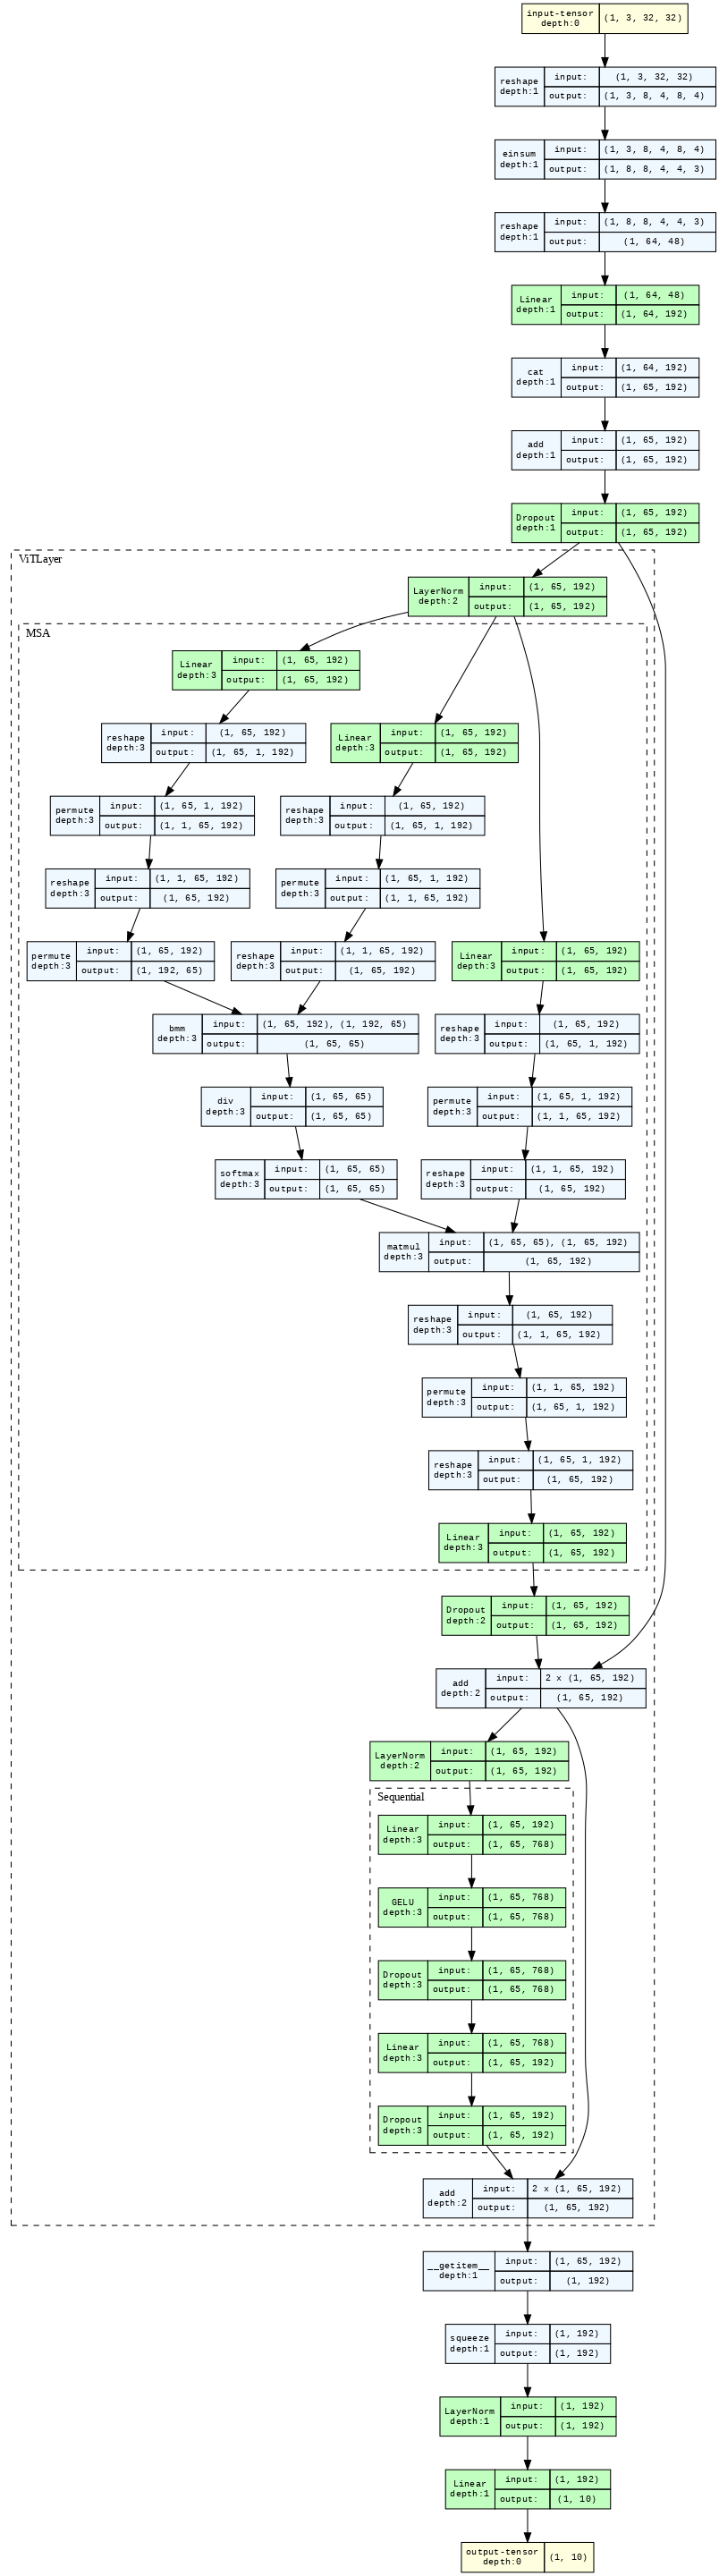

In [14]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model = ViT(patch_dim=4, image_dim=32, num_layers=1, num_heads=1, embed_dim=192, mlp_hidden_dim=768, num_classes=10, dropout=0.1)

# Draw the graph of the model
graph = draw_graph(model, input_size=(1, 3, 32, 32), expand_nested=True)

# Show the graph
graph.visual_graph

# Extra 1
Reproduce the plot of the Similarity of position embeddings as shown in Figure 7 of the [ViT Paper](https://arxiv.org/pdf/2010.11929.pdf)

Hint: access to the positional embedding with vit.module.position_embedding



In [15]:
embs = vit.module.position_embedding.detach().cpu()

In [16]:
embs.shape

torch.Size([1, 65, 384])

In [17]:
import torch.nn.functional as F

embs = embs.squeeze()
similarity = F.normalize(embs, dim=1) @ F.normalize(embs, dim=1).T
similarity

tensor([[ 1.0000, -0.0308, -0.1251,  ..., -0.0053, -0.0185,  0.0318],
        [-0.0308,  1.0000,  0.8411,  ..., -0.2838, -0.1482,  0.2477],
        [-0.1251,  0.8411,  1.0000,  ..., -0.2974, -0.1532,  0.0559],
        ...,
        [-0.0053, -0.2838, -0.2974,  ...,  1.0000,  0.8600,  0.6301],
        [-0.0185, -0.1482, -0.1532,  ...,  0.8600,  1.0000,  0.7290],
        [ 0.0318,  0.2477,  0.0559,  ...,  0.6301,  0.7290,  1.0000]])

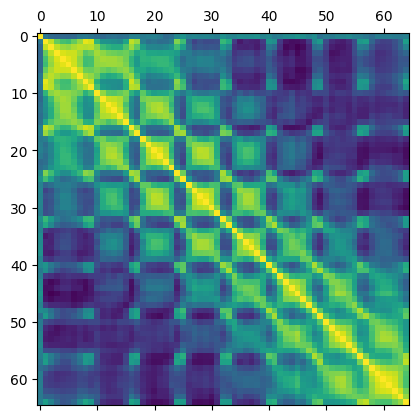

In [18]:
import matplotlib.pyplot as plt
plt.matshow(similarity.numpy())

# Extra 2
Reproduce the plot shown in Figure 6 ([ViT Paper](https://arxiv.org/pdf/2010.11929.pdf)) with images that you wish.

 Hint: Compute the attention that the CLS tokens pay with respect to the rest of the sequence. Then reshape these tensor to have the dimensionalities of an image. To aggregate the attention weights of more CLSs you can take the average. Obviously, you need to change the code of your MSA module so that it gives as output both the output of the attention mechanism and the attention weights.

In [70]:
import requests
from PIL import Image
import torch
from torchvision import transforms

# URL of the image
#url = "https://i.ytimg.com/vi/Cs12sfnFkYs/hqdefault.jpg"
url = "https://www.my-personaltrainer.it/2023/07/26/gatto-che-fissa_900x760.jpeg"

# Send a HTTP request to the URL of the image
response = requests.get(url, stream=True)
response.raise_for_status()

image = Image.open(response.raw)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

inp = transform(image)
inp = inp.unsqueeze(0)

In [71]:
# To get the output of the last encoder, a forward_hook needs to be defined
hooks_outputs = []

def my_hook(module, input, output):
  hooks_outputs.append(output)

vit.module.encoder_layers[-1].msa.return_attn_weights = True
vit.module.encoder_layers[-1].msa.register_forward_hook(my_hook)

outputs = vit(inp)
classes[torch.argmax(outputs, dim=1).item()]

'cat'

<BarContainer object of 10 artists>

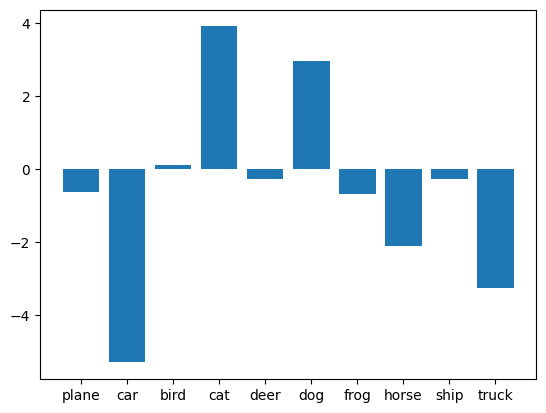

In [84]:
plt.bar(classes, outputs[0].detach().cpu().numpy())

In [72]:
_, weights = hooks_outputs[0] # attn weights of the last encoder layer
weights = weights.detach().cpu()
weights.shape

torch.Size([6, 65, 65])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

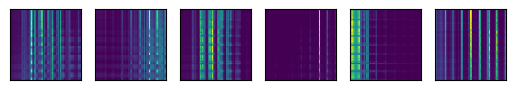

In [73]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, weights.shape[0])

for head_idx in range(weights.shape[0]):
  axes[head_idx].matshow(weights[head_idx].numpy())
  axes[head_idx].set_xticks([])
  axes[head_idx].set_yticks([])

plt

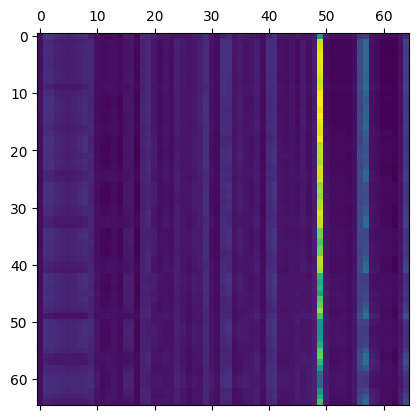

In [74]:
weights = weights.mean(dim=0)
plt.matshow(weights.numpy())

In [75]:
patches_weights = F.normalize(weights[0, :], dim=-1)[1:]
patches_weights = patches_weights.reshape(8, 8)

pixel_weights = torch.zeros((32, 32), dtype=torch.float32)

for r in range(8):
  for c in range(8):
    pixel_weights[(4*r):(4*(r+1)), (4*c):(4*(c+1))] = patches_weights[r, c]

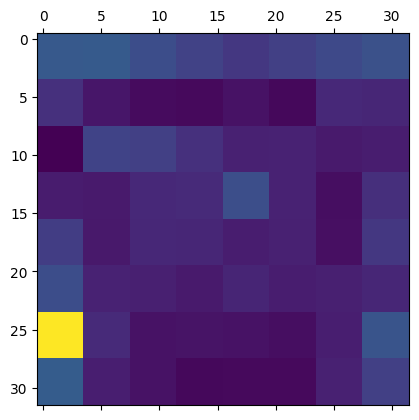

In [76]:
plt.matshow(pixel_weights.numpy())

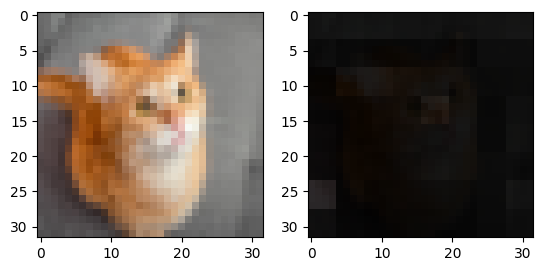

In [77]:
original = inp.squeeze(0).permute(1, 2, 0)
focus = (inp.squeeze(0) * pixel_weights).permute(1, 2, 0)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(original)
axes[1].imshow(focus)
plt.show()